In [1]:
import time
import torchvision.models as tm
import torch
import colossalai
from colossalai.fx import symbolic_trace, metainfo_trace
from colossalai.auto_parallel.checkpoint import CheckpointSolverRotor
from functools import partial
from colossalai.utils import free_port

from bench_utils import bench, bench_rotor, gpt2_medium, GPTLMLoss
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
colossalai.launch(config={}, rank=0, world_size=1, host='localhost', port=free_port(), backend='nccl')

[11/11/22 01:06:34] INFO     colossalai - torch.distributed.distributed_c10d - INFO: Added   
                             key: store_based_barrier_key:1 to store for rank: 0

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Rank 0: 
                             Completed store-based barrier for key:store_based_barrier_key:1 
                             with 1 nodes.

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Added   
                             key: store_based_barrier_key:2 to store for rank: 0

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Rank 0: 
                             Completed store-based barrier for key:store_based_barrier_key:2 
                             with 1 nodes.

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Added   
                             key: store_based_barrier_key:3 to store for rank: 0

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Rank 0: 
                             Completed store-based barrier for key:store_based_barrier_key:3 
                             with 1 nodes.

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Added   
                             key: store_based_barrier_key:4 to store for rank: 0

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Rank 0: 
                             Completed store-based barrier for key:store_based_barrier_key:4 
                             with 1 nodes.

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Added   
                             key: store_based_barrier_key:5 to store for rank: 0

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Rank 0: 
                             Completed store-based barrier for key:store_based_barrier_key:5 
                             with 1 nodes.

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Added   
                             key: store_based_barrier_key:6 to store for rank: 0

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Rank 0: 
                             Completed store-based barrier for key:store_based_barrier_key:6 
                             with 1 nodes.

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Added   
                             key: store_based_barrier_key:7 to store for rank: 0

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Rank 0: 
                             Completed store-based barrier for key:store_based_barrier_key:7 
                             with 1 nodes.

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Added   
                             key: store_based_barrier_key:8 to store for rank: 0

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Rank 0: 
                             Completed store-based barrier for key:store_based_barrier_key:8 
                             with 1 nodes.

                    INFO     colossalai - colossalai - INFO: /home/lcyby/Automatic_Paralleliz
                             ation/colossal/ColossalAI/colossalai/context/parallel_context.py
                             :521 set_device

                    INFO     colossalai - colossalai - INFO: process rank 0 is bound to      
                             device 0

                    INFO     colossalai - colossalai - INFO: /home/lcyby/Automatic_Paralleliz
                             ation/colossal/ColossalAI/colossalai/context/parallel_context.py
                             :557 set_seed

[11/11/22 01:06:35] INFO     colossalai - colossalai - INFO: initialized seed on rank 0,     
                             numpy: 1024, python random: 1024, ParallelMode.DATA: 1024,      
                             ParallelMode.TENSOR: 1024,the default parallel seed is          
                             ParallelMode.DATA.

                    INFO     colossalai - colossalai - INFO: /home/lcyby/Automatic_Paralleliz
                             ation/colossal/ColossalAI/colossalai/initialize.py:117 launch

                    INFO     colossalai - colossalai - INFO: Distributed environment is      
                             initialized, data parallel size: 1, pipeline parallel size: 1,  
                             tensor parallel size: 1

### ResNet152 with batch size = 512 fails

In [2]:
def data_gen(batch_size, shape, device='cuda'):
    data = torch.empty(batch_size, *shape, device=device)
    label = torch.empty(batch_size, dtype=torch.long, device=device).random_(1000)
    return (data,), label

model = tm.resnet152()
gm = symbolic_trace(model)
gm = metainfo_trace(gm, torch.empty(512, 3, 224, 224, device='meta'))
bench(gm, torch.nn.CrossEntropyLoss(), partial(data_gen, batch_size=512, shape=(3, 224, 224)), num_steps=5)


(78990.4404296875, inf)

### ResNet152 with batch size = 2048 succeeds 

In [3]:
def data_gen(batch_size, shape, device='cuda'):
    data = torch.empty(batch_size, *shape, device=device)
    label = torch.empty(batch_size, dtype=torch.long, device=device).random_(1000)
    return (data,), label

model = tm.resnet152()
gm = symbolic_trace(model)
gm = metainfo_trace(gm, torch.empty(2048, 3, 224, 224, device='meta'))
solver = CheckpointSolverRotor(gm.graph, free_memory=torch.cuda.mem_get_info(device=0)[0] * 0.95)
gm.graph = solver.solve()
bench(gm, torch.nn.CrossEntropyLoss(), partial(data_gen, batch_size=2048, shape=(3, 224, 224)), num_steps=5)

(74495.8486328125, 5654.436111450195)

### Benchmarking on ResNet50

In [4]:
def data_gen(batch_size, shape, device='cuda'):
    data = torch.empty(batch_size, *shape, device=device)
    label = torch.empty(batch_size, dtype=torch.long, device=device).random_(1000)
    return (data,), label

model = tm.resnet50()
gm = symbolic_trace(model)
gm = metainfo_trace(gm, torch.empty(128, 3, 224, 224, device='meta'))
budgets, peak_hist, step_hist = bench_rotor(gm, torch.nn.CrossEntropyLoss(), partial(data_gen, batch_size=128, shape=(3, 224, 224)), num_steps=5, sample_points=15, free_memory=11000 * 1024**2)

[11/11/22 01:07:20] WARNING  colossalai - colossalai - WARNING: /home/lcyby/Automatic_Paralle
                             lization/colossal/ColossalAI/colossalai/auto_parallel/checkpoint
                             /ckpt_solver_rotor.py:86 solve

                    WARNING  colossalai - colossalai - WARNING: Checkpoint solver failed: Can
                             not process this chain from index 0 to 22 with memory 500

(0.8, 1.5)

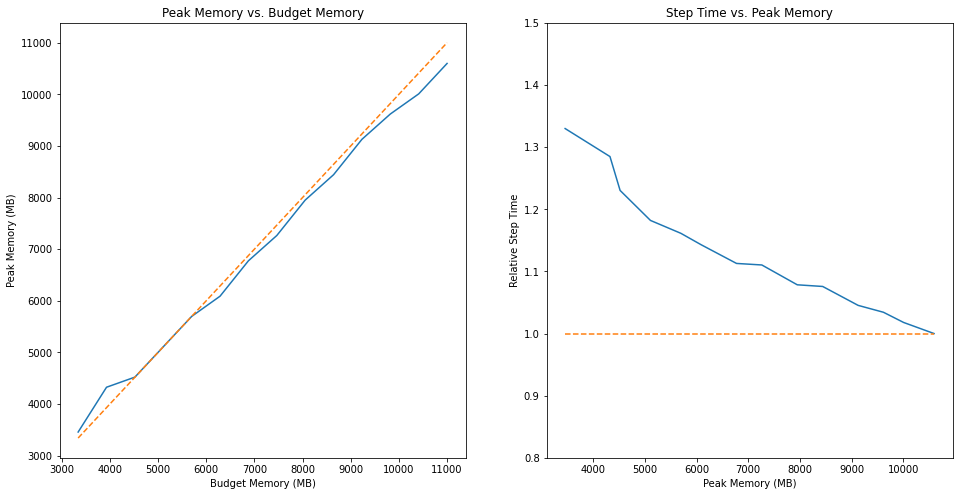

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
valid_idx = step_hist.index(next(step for step in step_hist if step != float("inf")))
axs[0].plot(budgets[valid_idx:], peak_hist[valid_idx:])
axs[0].plot([budgets[valid_idx], budgets[-1]], [budgets[valid_idx], budgets[-1]], linestyle='--')
axs[0].set_xlabel("Budget Memory (MB)")
axs[0].set_ylabel("Peak Memory (MB)")
axs[0].set_title("Peak Memory vs. Budget Memory")

axs[1].plot(peak_hist[valid_idx:], [step_time / step_hist[-1] for step_time in step_hist[valid_idx:]])
axs[1].plot([peak_hist[valid_idx], peak_hist[-1]], [1.0, 1.0], linestyle='--')
axs[1].set_xlabel("Peak Memory (MB)")
axs[1].set_ylabel("Relative Step Time")
axs[1].set_title("Step Time vs. Peak Memory")
axs[1].set_ylim(0.8, 1.5)

### Benchmark on GPT

In [6]:
def data_gen(batch_size, seq_len, vocab_size, device='cuda:0'):
    input_ids = torch.randint(0, vocab_size, (batch_size, seq_len), device=device)
    attention_mask = torch.ones_like(input_ids, device=device)
    return (input_ids, attention_mask), attention_mask

model = gpt2_medium()
data, mask = data_gen(8, 1024, 50257, device='meta')[0]
gm = symbolic_trace(model, meta_args={'input_ids': data, 'attention_mask': mask})
gm = metainfo_trace(gm, data, mask)
budgets, peak_hist, step_hist = bench_rotor(gm, GPTLMLoss(), partial(data_gen, batch_size=8, seq_len=1024, vocab_size=50257), num_steps=5, sample_points=15, free_memory=56000 * 1024**2, start_factor=10)

[11/11/22 01:08:08] WARNING  colossalai - colossalai - WARNING: /home/lcyby/Automatic_Paralle
                             lization/colossal/ColossalAI/colossalai/auto_parallel/checkpoint
                             /ckpt_solver_rotor.py:86 solve

                    WARNING  colossalai - colossalai - WARNING: Checkpoint solver failed: Can
                             not process this chain from index 0 to 57 with memory 500

(0.8, 1.5)

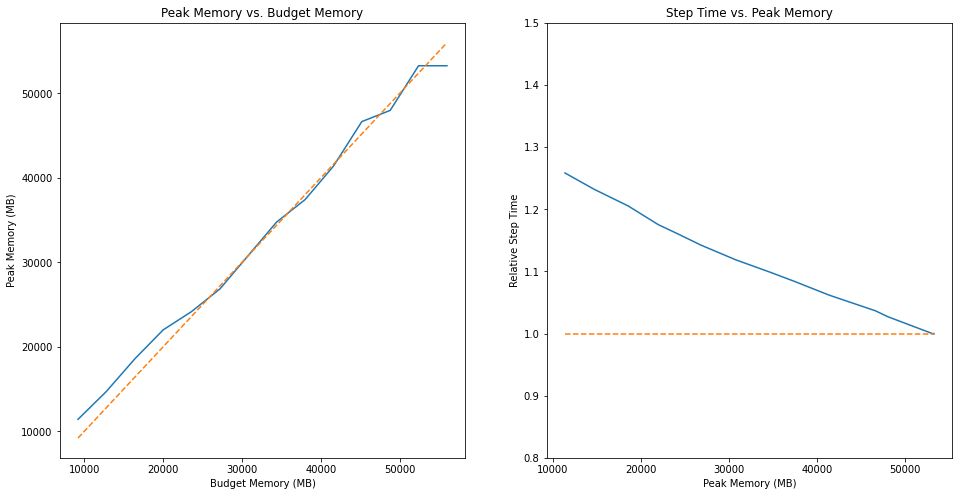

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
valid_idx = step_hist.index(next(step for step in step_hist if step != float("inf")))
axs[0].plot(budgets[valid_idx:], peak_hist[valid_idx:])
axs[0].plot([budgets[valid_idx], budgets[-1]], [budgets[valid_idx], budgets[-1]], linestyle='--')
axs[0].set_xlabel("Budget Memory (MB)")
axs[0].set_ylabel("Peak Memory (MB)")
axs[0].set_title("Peak Memory vs. Budget Memory")

axs[1].plot(peak_hist[valid_idx:], [step_time / step_hist[-1] for step_time in step_hist[valid_idx:]])
axs[1].plot([peak_hist[valid_idx], peak_hist[-1]], [1.0, 1.0], linestyle='--')
axs[1].set_xlabel("Peak Memory (MB)")
axs[1].set_ylabel("Relative Step Time")
axs[1].set_title("Step Time vs. Peak Memory")
axs[1].set_ylim(0.8, 1.5)